# Logrank with Imprint


In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import scipy.stats
import matplotlib.pyplot as plt

from imprint.nb_util import setup_nb
setup_nb()
import imprint as ip

In [2]:
@jax.jit
def logrank_test(all_rvs, group, censoring_time):
    n = all_rvs.shape[0]
    ordering = jnp.argsort(all_rvs)
    ordered = all_rvs[ordering]
    ordered_group = group[ordering]
    include = ordered <= censoring_time
    event_now = jnp.stack((~ordered_group, ordered_group), axis=0) * include
    events_so_far = jnp.concatenate(
        (jnp.zeros((2, 1)), event_now.cumsum(axis=1)[:, :-1]), axis=1
    )
    Nij = n - events_so_far
    Oij = event_now
    Nj = Nij.sum(axis=0)
    Oj = Oij.sum(axis=0)
    Eij = Nij * (Oj / Nj)
    Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
    denom = jnp.sum(jnp.where(~jnp.isnan(Vij[0]), Vij[0], 0), axis=0)
    return jnp.sum(Oij[0] - Eij[0], axis=0) / jnp.sqrt(denom)
    # To match with the lifelines implementation, we square everything. This is
    # a weird because it means that a one sided test is impossible.
    # To match with the C++ imprint implementation, we don't square anything.
    # This seems obviously better because otherwise a one sided test would be
    # impossible.
    # return jnp.sum(Oij[0] - Eij[0], axis=0) ** 2 / denom


In [14]:
# Survival analysis:
# - recruit n patients at t=0
# - observe them until censoring_time.
class LogRank:
    def __init__(self, seed, max_K, *, n, censoring_time):
        self.max_K = max_K
        self.censoring_time = censoring_time
        self.n = n
        self.family = "exponential"
        self.family_params = {"n": n}

        self.key = jax.random.PRNGKey(seed)
        self.samples = jax.random.exponential(self.key, shape=(max_K, n, 2))
        self.group = jnp.concatenate(
            [jnp.zeros((max_K, n)), jnp.ones((max_K, n))], axis=1
        ).astype(bool)
        self.vmap_logrank_test = jax.vmap(
            jax.vmap(logrank_test, in_axes=(0, 0, None)), in_axes=(0, None, None)
        )

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        control_hazard = theta[:, 0]
        treatment_hazard = theta[:, 1]
        hazard_ratio = treatment_hazard / control_hazard
        control_rvs = jnp.tile(self.samples[None, :, :, 0], (hazard_ratio.shape[0], 1, 1))
        treatment_rvs = self.samples[None, :, :, 1] / hazard_ratio[:, None, None]
        all_rvs = jnp.concatenate([control_rvs, treatment_rvs], axis=2)
        print(theta.shape, all_rvs.shape, self.group.shape, self.censoring_time)
        test_stat = self.vmap_logrank_test(
            all_rvs, self.group, self.censoring_time
        )
        return test_stat

In [15]:
g = ip.cartesian_grid([1, 1], [1, 1], n=[1, 1], null_hypos=[ip.hypo("theta0 > theta1")])

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=1, worker_id=1, t=1674868756, n_bits=18, worker_bits=18) = [4415640071538212864, ...]:


In [16]:
lr = LogRank(0, 10000, n=100, censoring_time=10000000)
stats = lr.sim_batch(0, lr.max_K, g.get_theta(), g.get_null_truth())

[1.]
(1, 2) (1, 10000, 200) (10000, 200) 10000000


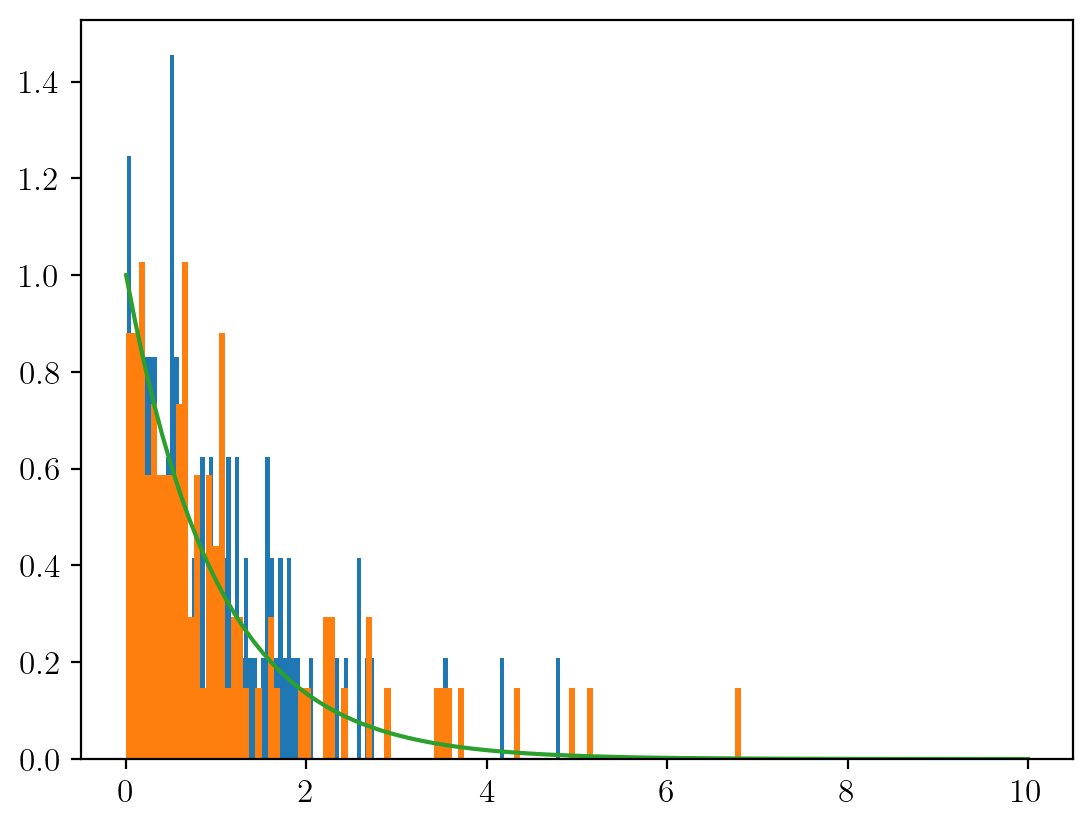

In [17]:
# plot lr.samples[0,:,0] and lr.samples[0,:,1] on the same plot
plt.figure()
plt.hist(lr.samples[0,:,0], bins=100, density=True, label='control')
plt.hist(lr.samples[0,:,1], bins=100, density=True, label='treatment')
# and compare to an exponential distribution with lambda = 1
x = jnp.linspace(0, 10, 100)
plt.plot(x, scipy.stats.expon.pdf(x), label="exponential")

plt.show()

The log rank test statistic should be asymptotically standard normal when the null hypothesis is true! But it's not...

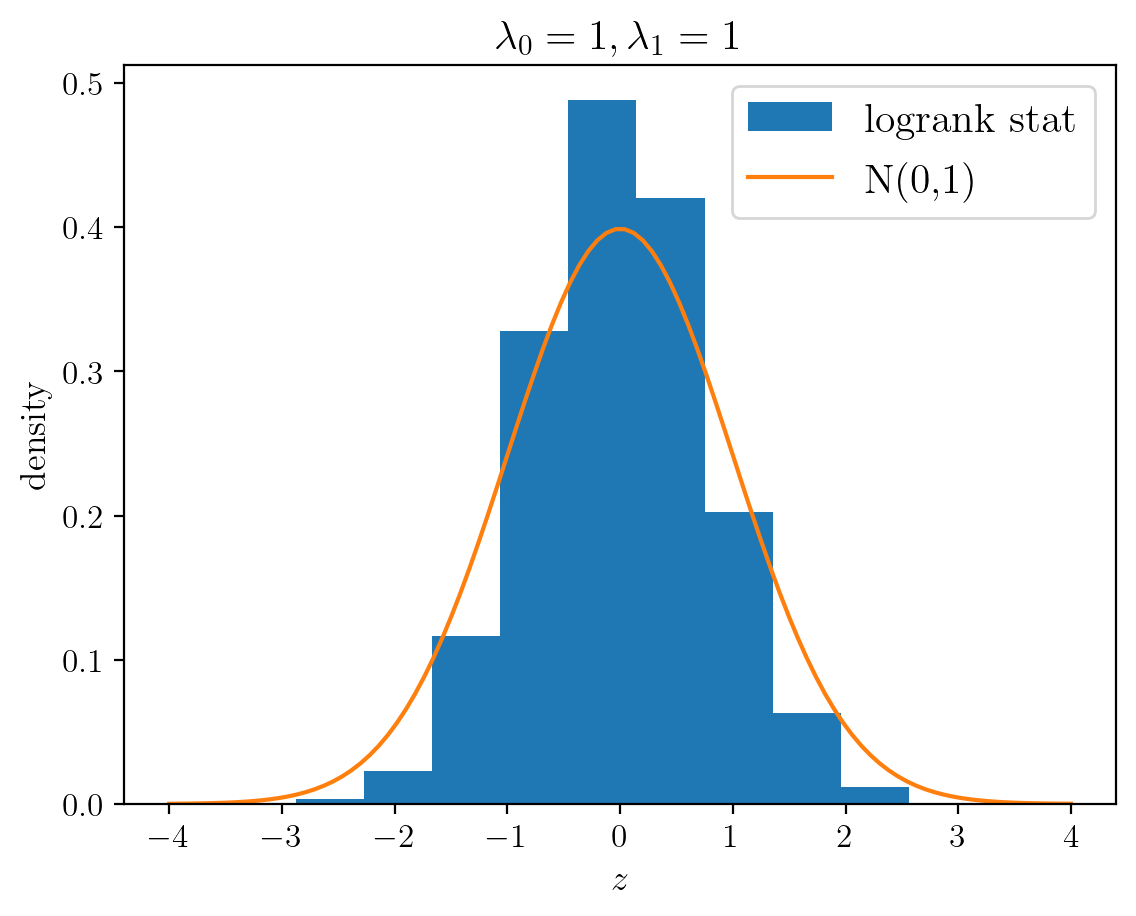

In [11]:
plt.title('$\lambda_0 = 1, \lambda_1 = 1$')
plt.hist(stats.flatten(), density=True, label='logrank stat')
xs = np.linspace(-4, 4, 100)
plt.plot(xs, scipy.stats.norm.pdf(xs), label='N(0,1)')
plt.xlabel('$z$')
plt.ylabel('density')
plt.legend()
plt.show()

In [ ]:
g = ip.cartesian_grid([0.2, 0.2], [4, 4], n=[10, 10], null_hypos=[ip.hypo("theta0 > theta1")])

In [10]:
rej_df = ip.validate(LogRank, g=g, lam=0.025, model_kwargs=dict(n=30, censoring_time=12))

(64, 2) (64, 16384, 60) (16384, 60) 12


In [11]:
rej_df

,tie_sum,tie_est,tie_cp_bound,tie_bound
0,0,0.000000,0.000281,NaN
1,0,0.000000,0.000281,NaN
2,5,0.000305,0.000800,NaN
3,175,0.010681,0.012702,NaN
4,1294,0.078979,0.084014,NaN
...,...,...,...,...
56,0,0.000000,0.000281,NaN
57,0,0.000000,0.000281,NaN
58,0,0.000000,0.000281,NaN
59,0,0.000000,0.000281,NaN


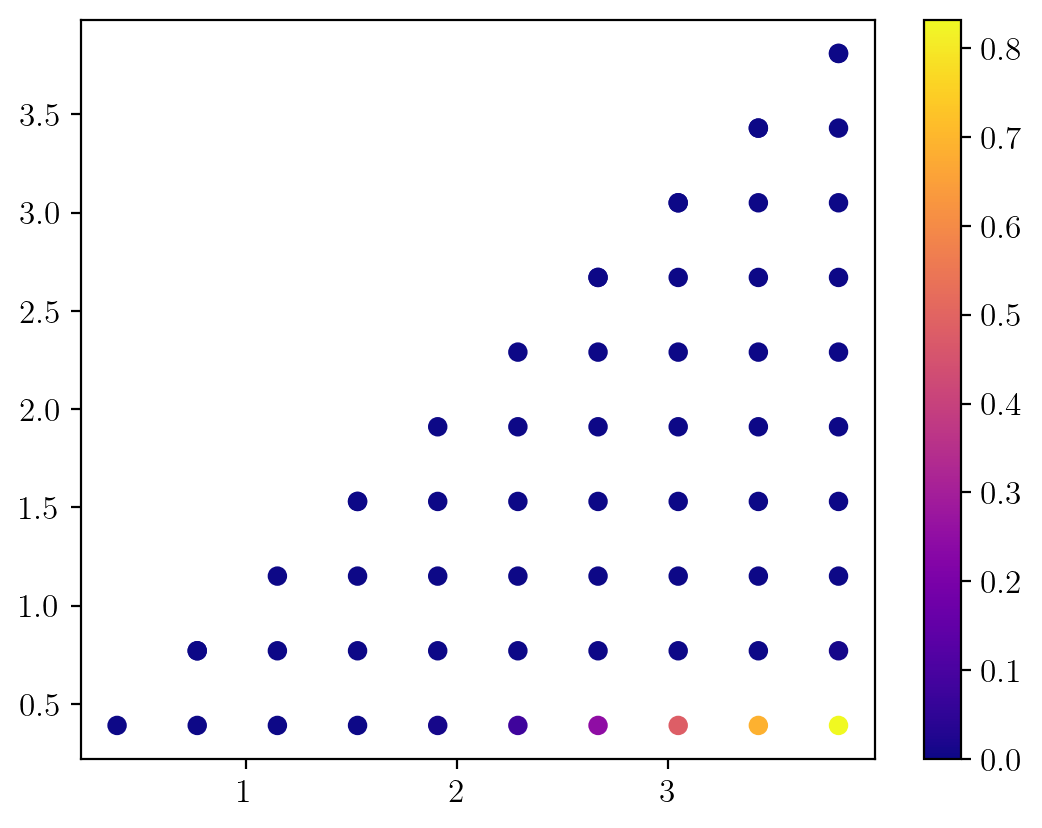

In [12]:
import matplotlib.pyplot as plt
plt.scatter(g.df['theta0'], g.df['theta1'], c=rej_df['tie_est'])
plt.colorbar()
plt.show()